In [66]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [67]:
df = pd.read_csv('/content/RSCCASN.csv',index_col='DATE',parse_dates=True)

In [68]:
df.head()

,RSCCASN
DATE,
1992-01-01,6938.0
1992-02-01,7524.0
1992-03-01,8475.0
1992-04-01,9401.0
1992-05-01,9558.0


<Axes: xlabel='DATE'>

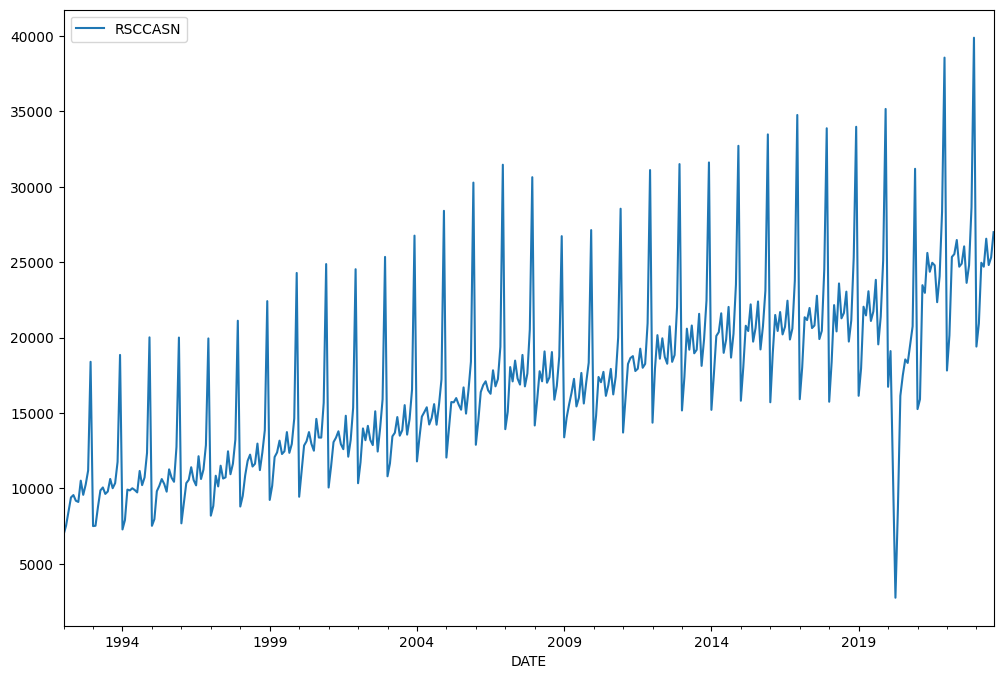

In [69]:
df.plot(figsize=(12,8))

In [70]:
test_size = 18

test_ind = len(df)- test_size

train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [71]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaler.fit(train)

scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [72]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

length = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)

X,y = generator[0]

In [73]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [74]:
n_features = 1

In [75]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [76]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 100)               40800     
                                                                 
 dense_4 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40901 (159.77 KB)
Trainable params: 40901 (159.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [77]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',patience=5)

In [78]:
validation_generator = TimeseriesGenerator(scaled_test,scaled_test, length=length, batch_size=1)

In [79]:
model.fit_generator(generator,epochs=20,
                    validation_data=validation_generator,
                   callbacks=[early_stop])

Epoch 1/20


<ipython-input-79-8ced39267a06>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator,epochs=20,


350/350 [==============================] - 5s 10ms/step - loss: 0.0209 - val_loss: 7.0895e-04
Epoch 2/20
350/350 [==============================] - 3s 8ms/step - loss: 0.0144 - val_loss: 0.0014
Epoch 3/20
350/350 [==============================] - 4s 11ms/step - loss: 0.0110 - val_loss: 0.0050
Epoch 4/20
350/350 [==============================] - 3s 9ms/step - loss: 0.0069 - val_loss: 0.0041
Epoch 5/20
350/350 [==============================] - 3s 8ms/step - loss: 0.0064 - val_loss: 0.0181
Epoch 6/20
350/350 [==============================] - 3s 8ms/step - loss: 0.0050 - val_loss: 0.0012


In [80]:
losses = pd.DataFrame(model.history.history)

<Axes: >

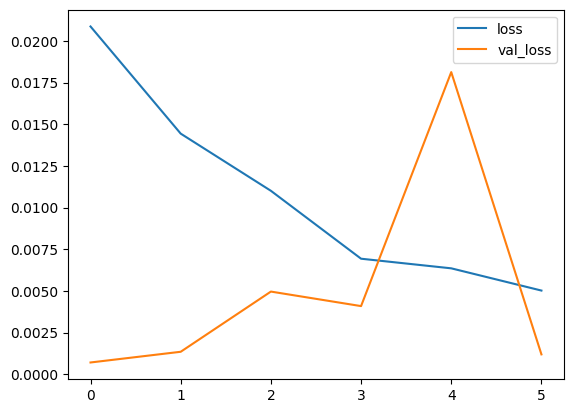

In [81]:
losses.plot()

In [82]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):

    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]

    # store prediction
    test_predictions.append(current_pred)

    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 26ms/step


In [83]:
true_predictions = scaler.inverse_transform(test_predictions)

In [84]:
test['Predictions'] = true_predictions

<ipython-input-84-920b79c3c314>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


In [85]:
test

,RSCCASN,Predictions
DATE,,
2022-03-01,25347.0,22068.296270
2022-04-01,25539.0,21831.961886
2022-05-01,26470.0,23556.813548
2022-06-01,24701.0,22930.716765
2022-07-01,24904.0,23376.643747
2022-08-01,26049.0,23328.648131
2022-09-01,23629.0,21821.639146
2022-10-01,24787.0,22842.138865
2022-11-01,28645.0,26718.496216


<Axes: xlabel='DATE'>

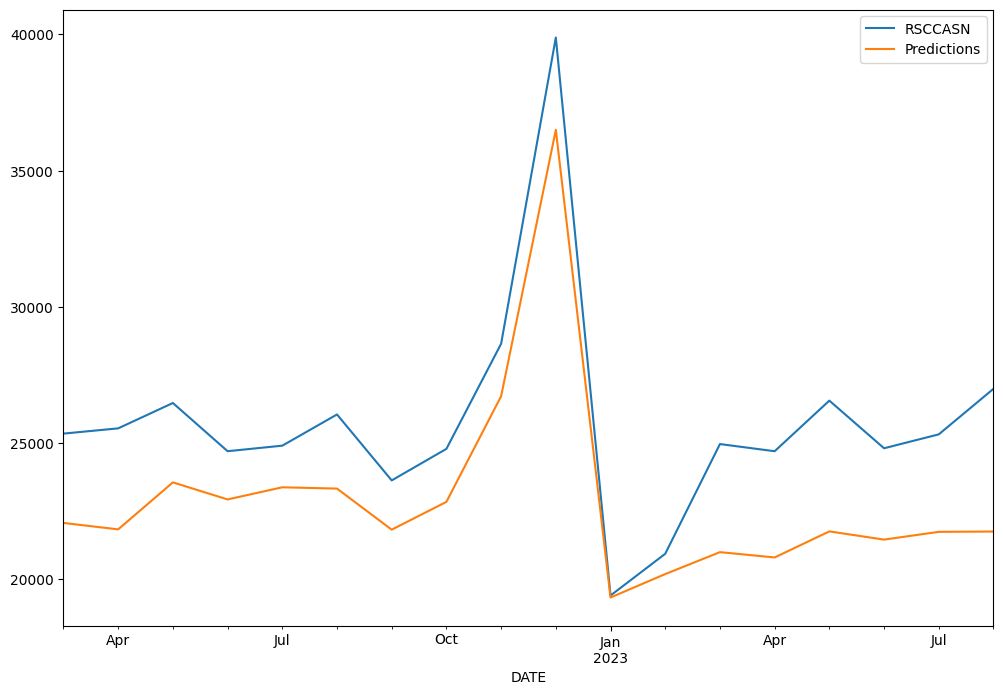

In [86]:
test.plot(figsize=(12,8))

In [87]:
#retrain and forecaust

In [88]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [89]:
length = 12 # Length of the output sequences (in number of timesteps)
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length=length, batch_size=1)

model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')


# fit model
model.fit_generator(generator,epochs=8)

Epoch 1/8


<ipython-input-89-161232aa53fb>:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator,epochs=8)


368/368 [==============================] - 5s 8ms/step - loss: 0.0183
Epoch 2/8
368/368 [==============================] - 3s 8ms/step - loss: 0.0128
Epoch 3/8
368/368 [==============================] - 4s 11ms/step - loss: 0.0089
Epoch 4/8
368/368 [==============================] - 3s 8ms/step - loss: 0.0060
Epoch 5/8
368/368 [==============================] - 3s 8ms/step - loss: 0.0057
Epoch 6/8
368/368 [==============================] - 5s 13ms/step - loss: 0.0043
Epoch 7/8
368/368 [==============================] - 5s 14ms/step - loss: 0.0054
Epoch 8/8
368/368 [==============================] - 3s 8ms/step - loss: 0.0048


In [90]:
forecast = []
# Replace periods with whatever forecast length you want
periods = 12

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):

    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]

    # store prediction
    forecast.append(current_pred)

    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 24ms/step


In [91]:
forecast = scaler.inverse_transform(forecast)

In [92]:
forecast

array([[25329.66509604],
       [26426.41989112],
       [30356.70480442],
       [46810.80166054],
       [22410.53265643],
       [23866.17341757],
       [27332.43880534],
       [27352.42683959],
       [29150.31039047],
       [27807.80352545],
       [28395.828269  ],
       [30086.42875695]])

In [93]:
forecast_index = pd.date_range(start='2019-11-01',periods=periods,freq='MS')

forecast_df = pd.DataFrame(data=forecast,index=forecast_index,
                           columns=['Forecast'])

<Axes: >

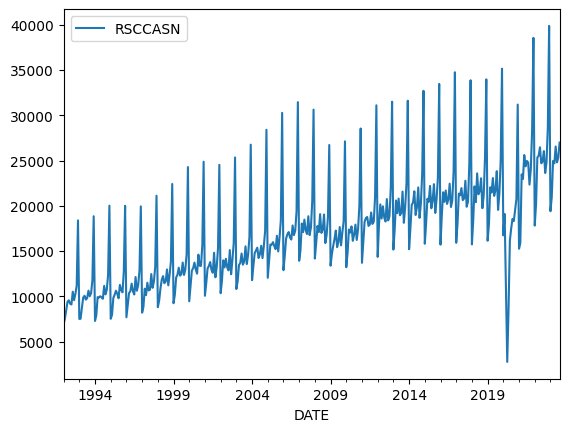

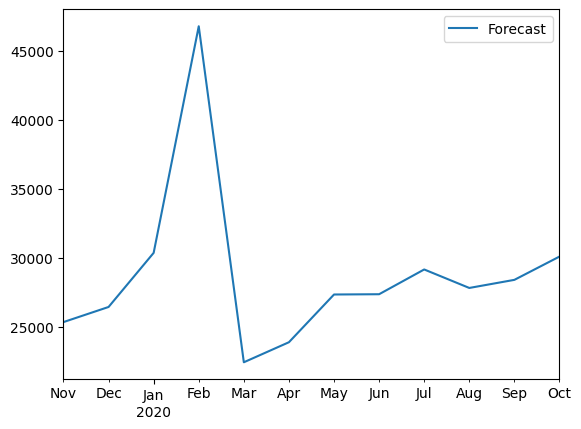

In [94]:
df.plot()
forecast_df.plot()

(576.0, 611.0)

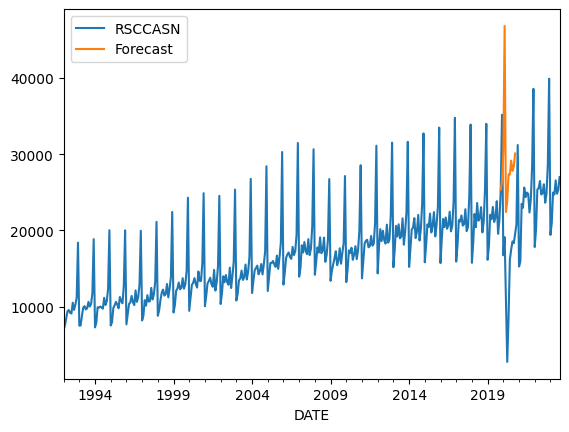

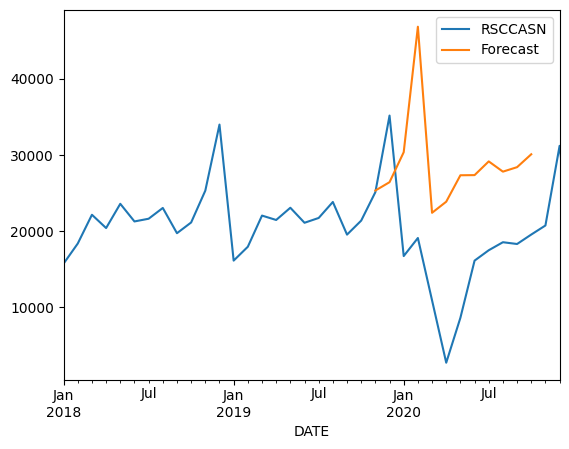

In [95]:
ax = df.plot()
forecast_df.plot(ax=ax)

ax = df.plot()
forecast_df.plot(ax=ax)
plt.xlim('2018-01-01','2020-12-01')